#  Homework 5 - Berkeley STAT 157

**Name: Benson Yuan, SID 3031807403**


**Please submit your homework through [gradescope](http://gradescope.com/) instead of Github, so you will get the score distribution for each question. Please enroll in the [class](https://www.gradescope.com/courses/42432) by the Entry code: MXG5G5** 

Handout 2/19/2019, due 2/26/2019 by 4pm in Git by committing to your repository.

In this homework, we will model covariate shift and attempt to fix it using logistic regression. This is a fairly realistic scenario for data scientists. To keep things well under control and understandable we will use [Fashion-MNIST](http://d2l.ai/chapter_linear-networks/fashion-mnist.html) as the data to experiment on. 

Follow the instructions from the Fashion MNIST notebook to get the data.

In [1]:
%matplotlib inline
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, nn, utils
import numpy as np
import matplotlib.pyplot as plt

mnist_train = gdata.vision.FashionMNIST(train=True)
mnist_test = gdata.vision.FashionMNIST(train=False)

## 1. Logistic Regression

1. Implement the logistic loss function $l(y,f) = -\log(1 + \exp(-y f))$ in Gluon.
2. Plot its values and its derivative for $y = 1$ and $f \in [-5, 5]$, using automatic differentiation in Gluon.
3. Generate training and test datasets for a binary classification problem using Fashion-MNIST with class $1$ being a combination of `shirt` and `sweater` and class $-1$ being the combination of `sandal` and `sneaker` categories. 
4. Train a binary classifier of your choice (it can be linear or a simple MLP such as from a previous lecture) using half the data (i.e. $12,000$ observations mixed as abvove) and one using the full dataset (i.e. $24,000$ observations as arising from the 4 categories) and report its accuracy. 

Hint - you should encapsulate the training and reporting code in a callable function since you'll need it quite a bit in the following. 

#### 1.1. Implement the logistic loss function $l(y,f) = -\log(1 + \exp(-y f))$ in Gluon.

In [2]:
def l(y, f):
    return -nd.log(1 + nd.exp(-y*f))

#### 1.2. Plot its values and its derivative for $y = 1$ and $f \in [-5, 5]$, using automatic differentiation in Gluon.

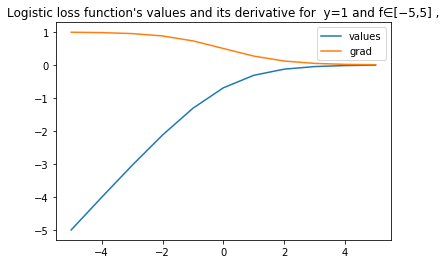

In [3]:
o = nd.arange(-5, 6) 
o_cop = nd.arange(-5, 6) 
y_pos = nd.zeros(len(o)) 
pos_loss = l(1, o)

o.attach_grad() 
with autograd.record():
    pos_loss = l(1, o)
pos_loss.backward()

plt.figure()
plt.plot(o.asnumpy(), pos_loss.asnumpy(), label = 'values') 
plt.plot(o.asnumpy(), o.grad.asnumpy(),label = 'grad')
plt.title("Logistic loss function's values and its derivative for  y=1 and f∈[−5,5] ,") 
plt.legend()
plt.show()

#### 1.3. Generate training and test datasets for a binary classification problem using Fashion-MNIST with class $1$ being a combination of `shirt` and `sweater` and class $-1$ being the combination of `sandal` and `sneaker` categories. 

In [4]:
import d2l

def preprocess(data):
    processed = []
    for i in range(len(data)):
        feature, label = data[i]
        label = d2l.get_fashion_mnist_labels([label])[0]
        if label == "shirt" or label == "t-shirt": # since there is no sweater, I chose t-shirt instead.
            processed.append((data[i][0].astype('float32').reshape(1, 784), nd.array([1])))
        elif label == "sandal" or label == "sneaker":
            processed.append((data[i][0].astype('float32').reshape(1, 784), nd.array([-1])))
    return processed

new_train = preprocess(mnist_train)
new_test = preprocess(mnist_test)

In [5]:
len(new_train) #sanity check that we get 24,000 observations as arising frmo the 4 categories. Good, it matches!

24000

#### 1.4. Train a binary classifier of your choice (it can be linear or a simple MLP such as from a previous lecture) using half the data (i.e. $12,000$ observations mixed as abvove) and one using the full dataset (i.e. $24,000$ observations as arising from the 4 categories) and report its accuracy. 

In [6]:
# First define some custom helper functions

def init_net():
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize(init.Normal(sigma=0.01))
    return net

def predict(y):
    return 1 if y[0].asscalar() > 0 else -1 

def train(train_iter, test_iter, loss, num_epochs, batch_size, lr=None):
    net = init_net()
    trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': lr})
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            with autograd.record():
                y_hat = net(X)
                l = loss(y_hat, y).sum()
            l.backward()
            trainer.step(batch_size)
            y = y.astype('float32')
            train_l_sum += l.asscalar()
            train_acc_sum += (predict(y_hat) == y).sum().asscalar()
            n += y.size
        test_acc = get_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))
    return net
        
def get_accuracy(data_iter, net):
    """Evaluate accuracy of a model on the given data set."""
    acc_sum, n = nd.array([0]), 0
    for X, y in data_iter:
        y = y.astype('float32')
        acc_sum += (predict(net(X)) == y).sum()
        n += y.size
        #acc_sum.wait_to_read()
    
    return acc_sum.asscalar() / n

In [7]:
batch_size = 256
loss = gloss.LogisticLoss()
num_epochs, lr = 5, 0.5
half = int(len(new_train)/2)
halved = new_train[:half]
print("Starting training on half of the dataset")
print()
trained_half = train(halved, new_test, loss, num_epochs, batch_size, lr)
print("Starting training on the full dataset")
trained_full = train(new_train, new_test, loss, num_epochs, batch_size, lr)

Starting training on half of the dataset

epoch 1, loss 211.7252, train acc 0.995, test acc 0.997
epoch 2, loss 196.3562, train acc 0.998, test acc 0.997
epoch 3, loss 63.7366, train acc 0.999, test acc 0.997
epoch 4, loss 107.5051, train acc 0.999, test acc 0.998
epoch 5, loss 61.9125, train acc 0.999, test acc 0.999
Starting training on the full dataset
epoch 1, loss 242.6006, train acc 0.996, test acc 0.997
epoch 2, loss 193.8790, train acc 0.998, test acc 0.997
epoch 3, loss 164.3251, train acc 0.999, test acc 0.998
epoch 4, loss 148.6809, train acc 0.999, test acc 0.997
epoch 5, loss 141.0904, train acc 0.999, test acc 0.998


## 2. Covariate Shift

Your goal is to introduce covariate shit in the data and observe the accuracy.

For this, compose a dataset of 12, 000 observations, given by a mixture of shirt and t-shirt and of sandal and sneaker respectively, where you use a fraction λ ∈ {0.05, 0.1, 0.2, . . . 0.8, 0.9, 0.95} of one (shirt and t-shirt) and a fraction of 1 − λ of the other datasets (sandal and sneaker) respectively.

For instance, you might pick for λ = 0.1 a total of 600 shirt and 600 t-shirt images and likewise 5,400 sandal and 5, 400 sneaker photos, yielding a total of 12, 000 images for training. Note that the test set remains unbiased, composed of 2, 000 photos for the shirt + t-shirt category and of the sandal + sneaker category each.

#### 1. Generate training sets that are appropriately biased. You should have 11 datasets.

In [12]:
def get_indices_of_label(labels):
    indices_map = {}
    for i in labels:
        indices_map[i] = list()
    for i in range(len(mnist_train)):
        _, label = mnist_train[i]
        if label in indices_map:
            indices_map[label].append(i)
    return indices_map 

# 0 = tshirt, 5 = sandal, 6 = shirt, 7 = sneaker.
labels = [0, 5, 6, 7]
indices_map = get_indices_of_label(labels) # indices map stores indices of each of the classes.

In [13]:
def split_data(frac, indices_map):
    num_per_class = len(indices_map[0])
    size_class_one = int(frac * num_per_class)
    size_class_two = int((1 - frac) * num_per_class)
    tshirt_indices = np.random.choice(indices_map[0], size=size_class_one, replace = False)
    shirt_indices = np.random.choice(indices_map[6], size=size_class_one, replace = False)
    shirts_indices = np.concatenate((tshirt_indices, shirt_indices), axis=0)

    sandal_indices = np.random.choice(indices_map[5], size=size_class_two, replace = False)
    sneaker_indices = np.random.choice(indices_map[7], size=size_class_two, replace = False)
    shoes_indices = np.concatenate((sandal_indices, sneaker_indices), axis=0)
    
    processed = []
    for i in np.concatenate((shirts_indices, shoes_indices), axis=0):
        feature, label = mnist_train[i]
        if label == 0 or label == 6: # since there is no sweater, I chose t-shirt instead.
            processed.append((mnist_train[i][0].astype('float32').reshape(1, 784), nd.array([1])))
        elif label == 5 or label == 7:
            processed.append((mnist_train[i][0].astype('float32').reshape(1, 784), nd.array([-1])))
    return processed

In [14]:
splitted_data = []
frac = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
for f in frac:
    splitted_data.append(split_data(f, indices_map))

#### 2. Train a binary classifier using this and report the test set accuracy on the unbiased test set. 

In [15]:
trained = []
num_epochs, lr = 3, 0.5
loss = gloss.LogisticLoss()
for i, datum in enumerate(splitted_data):
     trained.append(train(datum, new_test, loss, num_epochs, 256, lr))

epoch 1, loss 2.8294, train acc 1.000, test acc 0.500
epoch 2, loss 31.7829, train acc 0.999, test acc 0.507
epoch 3, loss 25.9701, train acc 0.999, test acc 0.758
epoch 1, loss 0.0217, train acc 1.000, test acc 0.500
epoch 2, loss 33.0224, train acc 0.999, test acc 0.501
epoch 3, loss 26.8802, train acc 0.999, test acc 0.779
epoch 1, loss 0.3424, train acc 1.000, test acc 0.500
epoch 2, loss 95.2141, train acc 0.999, test acc 0.713
epoch 3, loss 11.6094, train acc 0.999, test acc 0.766
epoch 1, loss 0.3038, train acc 1.000, test acc 0.500
epoch 2, loss 78.3453, train acc 0.999, test acc 0.501
epoch 3, loss 46.5414, train acc 0.999, test acc 0.794
epoch 1, loss 0.0048, train acc 1.000, test acc 0.500
epoch 2, loss 85.5992, train acc 0.999, test acc 0.501
epoch 3, loss 63.4472, train acc 0.999, test acc 0.878
epoch 1, loss 0.0748, train acc 1.000, test acc 0.500
epoch 2, loss 61.7979, train acc 0.999, test acc 0.502
epoch 3, loss 25.1434, train acc 1.000, test acc 0.748
epoch 1, loss 5.

## 3. Covariate Shift Correction

Having observed that covariate shift can be harmful, let's try fixing it. For this we first need to compute the appropriate propensity scores $\frac{dp(x)}{dq(x)}$. For this purpose pick a biased dataset, let's say with $\lambda = 0.1$ and try to fix the covariate shift.

1. When training a logistic regression binary classifier to fix covariate shift, we assumed so far that both sets are of equal size. Show that re-weighting data in training and test set appropriately can help address the issue when both datasets have different size. What is the weighting?
2. Train a binary classifier (using logistic regression) distinguishing between the biased training set and the unbiased test set. Note - you need to weigh the data. 
3. Use the scores to compute weights on the training set. Do they match the weight arising from the biasing distribution $\lambda$? 
4. Train a binary classifier of the covariate shifted problem using the weights obtained previously and report the accuracy. Note - you will need to modify the training loop slightly such that you can compute the gradient of a weighted sum of losses. 


Assume that we want to estimate some dependency  p(y|x)  for which we have labeled data  (xi,yi). However, the observations  xi  are drawn from some distribution  q(x)  rather than the ‘proper’ distribution  p(x). We will show that regardless, we can find a proper weighting to reweight the data to correct covariate shift.

$$\int_{}^{} p(x)f(x) dx = \int_{}^{} q(x)f(x) \frac{p(x)}{q(x)} dx$$

On the left, we want to model p(x)f(x), however, if covariate shift occurs, we only have access to q(x)f(x). However, we can estimate the weighting to be $\beta(x) = \frac{p(x)}{q(x)}$ which we will multiply with $ q(x)f(x)$ to get $p(x)f(x)$ to correct the model.

In [16]:
def train_with_weight(weight, train_iter, test_iter, loss, num_epochs, batch_size, lr=None):
    net = init_net()
    trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': lr})
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            with autograd.record():
                y_hat = net(X)
                l = loss(y_hat, y).sum() * weight
            l.backward()
            trainer.step(batch_size)
            y = y.astype('float32')
            train_l_sum += l.asscalar()
            train_acc_sum += (predict(y_hat) == y).sum().asscalar()
            n += y.size
        test_acc = get_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))
    return net

biased_dataset = splitted_data[1]

train_test_mix = []
for i in range(len(biased_dataset)):
    train_test_mix.append((biased_dataset[i][0].astype('float32').reshape(1, 784), nd.array([-1])))
for i in range(len(new_test)):
    train_test_mix.append((new_test[i][0].astype('float32').reshape(1, 784), nd.array([1])))
    
num_epochs, lr = 3, 0.5
loss = gloss.LogisticLoss()
result = train_with_weight(1/3, train_test_mix, new_test, loss, num_epochs, 256, lr) #2000/6000 = 1/3

epoch 1, loss 6.3626, train acc 1.000, test acc 0.500
epoch 2, loss 290.0754, train acc 0.999, test acc 0.500
epoch 3, loss 251.4783, train acc 0.999, test acc 0.500


Nice, we are able to achieve nearly 100% accuracy on the training set, which means that we are able to distinguish p(x) from q(x). Note that the test acc don't matter at this point because we are merely training the model in order to obtain B(x) = p(x)/q(x). (The test acc is merely an artifact from our regular classifier function).

Weigh training data using  $\beta i$ = $min(exp(f(xi)),c)$ to clip the correction factor. In this case, we will pick c = 100.

In [22]:
def covariate_counter_train2(f, train_iter, test_iter, loss, num_epochs, batch_size, lr=None):
    net = init_net()
    trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': lr})
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            with autograd.record():
                y_hat = net(X)
                l = min(nd.exp(f(X)).sum().asscalar(), 100) * loss(y_hat, y).sum()  
                #Above: we are reweighting by βi  = min(exp(f(xi)),100) to correct the covariate shift.
            l.backward()
            trainer.step(batch_size)
            y = y.astype('float32')
            train_l_sum += l.asscalar()
            train_acc_sum += (predict(y_hat) == y).sum().asscalar()
            n += y.size
        test_acc = get_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))
    return net

In [21]:
num_epochs, lr = 5, 0.5
covariate_counter_train2(result, splitted_data[1], new_test, loss, num_epochs, 256, lr)

epoch 1, loss 0.2838, train acc 1.000, test acc 0.500
epoch 2, loss 7724.2362, train acc 0.999, test acc 0.510
epoch 3, loss 3810.1495, train acc 0.999, test acc 0.754
epoch 4, loss 3480.3880, train acc 1.000, test acc 0.896
epoch 5, loss 1862.0473, train acc 1.000, test acc 0.956


In [43]:
train(splitted_data[1], new_test, loss, num_epochs, 256, lr)

epoch 1, loss 5.2141, train acc 1.000, test acc 0.500
epoch 2, loss 95.7691, train acc 0.999, test acc 0.524
epoch 3, loss 61.4966, train acc 0.999, test acc 0.831
epoch 4, loss 23.1460, train acc 1.000, test acc 0.943
epoch 5, loss 11.7775, train acc 1.000, test acc 0.837


Sequential(
  (0): Dense(784 -> 1, linear)
)

## Great! After 5 epochs, we have 0.956 test accuracy after correction shift correction compared to 0.837 before the correction.   